In [2]:
from scipy.io import arff
import pandas as pd
import numpy as np
import pydantic
import copy
import matplotlib.pyplot as plt
from typing import Union, Any, List, Optional
import argparse
import os
from loguru import logger
import yaml

from pydantic import BaseModel, Field
from typing import List, Optional, Tuple
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn import datasets

In [3]:
# compute metric

def if_empty_zero(array: np.array) -> np.array:
    if array.size == 0:
        array = 0

    return np.array(array)


def compute_variance_contribution(cov: np.array, comp: np.array, k: int, l: int, d: int) -> float:

    first_term = comp[k, l] ** 2 * cov[l, l]

    f1 = comp[k, :l] * comp[k, l] * cov[:l, l]
    f2 = comp[k, l+1:d] * comp[k, l] * cov[l+1:d, l]

    second_term = np.sum(if_empty_zero(f1)) + np.sum(if_empty_zero(f2))
    contribution = first_term + second_term

    return contribution


def get_contribs(cov: np.array, comp: int, p: int) -> np.array:
    arr_contrib = [[] for _ in range(p)]

    for pc_num in range(p):
        for feature_num in range(p):
            contrib = compute_variance_contribution(cov, comp, pc_num, feature_num, p)
            arr_contrib[pc_num].append(contrib)

    return np.array(arr_contrib)


def get_pca(data: np.array) -> tuple[PCA, np.array]:

    data = scale(data, axis=0)
    pca = PCA(n_components=data.shape[1])
    
    pca.fit(data)
    pca_transformed_data = pca.transform(data)

    return pca, pca_transformed_data


def compute_fitness(data_transformed: np.array,
                    training_mode: bool = True,
                    partial_contribution_objective: bool = False,
                    k: int = 1) -> Union[list, Any]:

    data_transformed = scale(data_transformed, axis=0)

    pca_model, pca_transformed_data = get_pca(copy.deepcopy(data_transformed))
    p = data_transformed.shape[1]
    cov_matrix = np.cov(np.transpose(data_transformed))

    variance_contrib = get_contribs(cov_matrix, pca_model.components_, p)

    if partial_contribution_objective:
        score = np.sum(variance_contrib[:k], axis=0)
    else:
        score = [np.sum(variance_contrib[:k])]*p

    return score, pca_transformed_data


# utils

In [4]:
def parse_arguments():
    config = config_load()

    parser = argparse.ArgumentParser(description="test", conflict_handler="resolve")
    parser.add_argument(
        "--dataset",
        default=config["dataset"],
        help="Specify the dataset.",
    )

    parser.add_argument(
        "--partial_contrib",
        type=str,
        default=config["partial_contribution_objective"],
        help="Specify whether or not to use partial contribution objective."
    )

    parser.add_argument(
        "--activation",
        type=str,
        default=config["activation"],
        help="Specify the activation function to use."
    )

    args = parser.parse_args()

    return args

In [5]:
def transform_data_onehot(data: pd.DataFrame, object_indices: list[int]) -> Tuple[pd.DataFrame, list[int]]:
    object_indices = np.array(object_indices)
    columns = data.columns[object_indices]

    for col in columns:
        data[col], _ = pd.factorize(data[col])

    num_cols_per_categories = [1] * data.shape[1]

    return data, num_cols_per_categories

In [6]:
class ConfigDataset(BaseModel):
    num_features: int
    synthetic_bool: bool
    categorical_features: Optional[List[int]] = Field(default_factory=list)
    numerical_features: Optional[List[int]] = Field(default_factory=list)

In [7]:
def dataset_config_load(file_path: str, dataset: str) -> ConfigDataset:
    """load config file into pydantic object"""
    with open(file_path) as file:
        config_data = yaml.safe_load(file)
        config_data = config_data[dataset]

    return ConfigDataset(**config_data)

# preprocess data

In [8]:
def get_split_indices(data: np.array, random_seed: int, val_prop: float = 0.2) -> Tuple[np.array, np.array]:
    np.random.seed(random_seed)
    n = data.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    train_indices = indices[int(n * val_prop):]
    val_indices = indices[:int(n * val_prop)]

    return train_indices, val_indices

In [9]:
def preprocess_data(data: pd.DataFrame, dataset: str, remove_class: bool = True):

    if dataset in ["phoneme", "breast_cancer"]:
        type_class = data["Class"]

    elif dataset == "abalone":
        type_class = data["sex"]

    elif dataset in ["wine", "ionosphere", "german_credit", "dermatology", "heart-statlog"]:
        type_class = data["class"]

    print("the number of classes is:", len(np.unique(type_class)))

    return data, type_class

In [10]:
def compute_explained_variance(data: np.array, pca_model: PCA):
    cov_matrix = np.cov(np.transpose(data))
    explained_var = np.matmul(np.matmul(pca_model.components_, cov_matrix), np.transpose(pca_model.components_))
    explained_var_ratio = np.diag(explained_var) / np.sum(np.diag(explained_var))

    # print("diag variance", np.sum(np.diag(explained_var)))
    # print(np.sum(np.var(data, axis=0)))
    
    return explained_var_ratio

In [11]:
def read_arff(path):
    data, meta = arff.loadarff(path)
    data = pd.DataFrame(data)
    return data

# perform the variance contrib on data

In [12]:
# Note: because in some cases the validation data is very small, there will be big variation in the explained
# variance..

In [13]:
dataset = "heart-statlog"

path = f"../datasets/{dataset}.arff"
data = read_arff(path)
data = data.dropna()

print(data.shape)

(270, 14)


In [14]:
dataset_config = dataset_config_load("../datasets_config.yaml", dataset)

In [15]:
data, num_cols_per_categories = transform_data_onehot(data, dataset_config.categorical_features)

In [16]:
classes = np.zeros(data.shape[0])

if dataset not in ["circles", "spheres", "alternate_stripes"]:
    data, classes = preprocess_data(data, dataset)
    classes, mapping = pd.factorize(classes)

logger.info(f"The column types of the dataset are: {data.dtypes}")

# transform categorical (object type in pandas) columns to one-hot encoded.
if dataset_config.categorical_features:
    data, num_features_per_network = transform_data_onehot(data, dataset_config.categorical_features)
else:
    num_features_per_network = np.array([1] * data.shape[1])

2025-01-03 20:55:04.956 | INFO     | __main__:<module>:7 - The column types of the dataset are: age                                     float64
sex                                       int64
chest                                     int64
resting_blood_pressure                  float64
serum_cholestoral                       float64
fasting_blood_sugar                       int64
resting_electrocardiographic_results      int64
maximum_heart_rate_achieved             float64
exercise_induced_angina                   int64
oldpeak                                 float64
slope                                   float64
number_of_major_vessels                 float64
thal                                      int64
class                                     int64
dtype: object


the number of classes is: 2


In [17]:
print(data.shape, data.columns)

(270, 14) Index(['age', 'sex', 'chest', 'resting_blood_pressure', 'serum_cholestoral',
       'fasting_blood_sugar', 'resting_electrocardiographic_results',
       'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak',
       'slope', 'number_of_major_vessels', 'thal', 'class'],
      dtype='object')


In [18]:
# Apply factorize on all object columns and replace them in the DataFrame
for col in data.select_dtypes(include=['object']).columns:
    data[col], _ = pd.factorize(data[col])

In [19]:
data = np.array(data)

In [20]:
# here, also use a scaler for train and then transform the val

explained_variance_list = []

for seed in range(30):
    
    scaler = StandardScaler()
    
    train_indices, val_indices = get_split_indices(copy.deepcopy(data), seed, 0.25)
    train_x, val_x = data[train_indices], data[val_indices]
    
    scaler.fit(train_x)
    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)
    
    train_class, val_class = classes[train_indices], classes[val_indices]

    pca = PCA()
    pca.fit(train_x)
    
    x_pca_train = pca.transform(train_x)
    
    x_pca_val = pca.transform(val_x)
    explained_variance_ratio = compute_explained_variance(val_x, pca)
    explained_variance_list.append(explained_variance_ratio)

In [21]:
np.quantile(np.array(explained_variance_list), axis=0, q=0.5)

array([0.25218469, 0.10262572, 0.07287859, 0.08125832, 0.06864069,
       0.05881451, 0.06315189, 0.05499933, 0.055315  , 0.05230687,
       0.03954669, 0.03705009, 0.02762616, 0.0338779 ])

In [22]:
def plot_principal_components(y, x):

    # Define unique classes and corresponding colors
    unique_classes = np.unique(y)
    colors = plt.cm.tab10(unique_classes)  # Use a colormap to assign colors
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.grid(True)
    
    # Plot each class separately to create a legend
    for cls, color in zip(unique_classes, colors):
        plt.scatter(
            x[y == cls, 0], 
            x[y == cls, 1], 
            alpha=0.5, edgecolor="k", c=[color], 
            label=f'Class {cls}'
        )
    
    plt.xlabel('First Dimension')
    plt.ylabel('Second Dimension')
    plt.title('Scatter Plot of First and Second Dimensions')
    plt.legend(title='Classes', fontsize=12)
    plt.show()

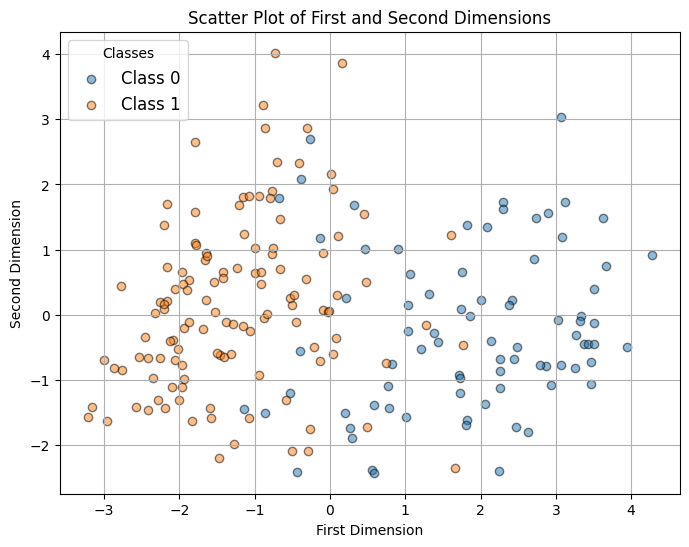

In [23]:
plot_principal_components(train_class, x_pca_train)

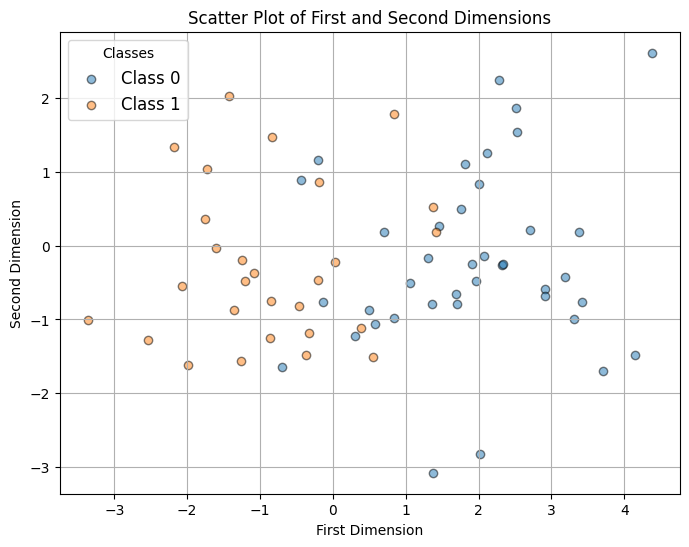

In [24]:
plot_principal_components(val_class, x_pca_val)

# PCA's biplot

In [29]:
def create_enhanced_biplot(pca: PCA, data: np.array, target: np.array, original_column_names: list[str]):
    
    # Create the plot with improved aesthetics
    plt.figure(figsize=(10, 8))
    
    # Discrete color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Scatter plot of data points with discrete colors
    for i in range(len(np.unique(target))):
        mask = target == i
        plt.scatter(data[mask, 0], data[mask, 1], 
                    color=colors[i], 
                    label=f'Class {i}',
                    edgecolor='black', 
                    linewidth=1, 
                    alpha=0.75)
    
    # Variable (feature) arrows
    components = pca.components_[0:2, :]
    for i, feature in enumerate(original_column_names):
        # Straight arrows
        plt.arrow(0, 0, components[0, i], components[1, i], 
                  color='red', 
                  head_width=0.05, 
                  head_length=0.1, 
                  alpha=0.7)
        
        # Add feature labels with slight offset
        plt.text(components[0, i]*1.2, 
                 components[1, i]*1.2, 
                 feature, 
                 color='darkred', 
                 ha='center', 
                 va='center', 
                 fontweight='bold',
                 fontsize=12)
    
    # Styling
    plt.title('PCA Biplot of Iris Dataset', fontsize=15)
    plt.xlabel(f'First Principal Component (Variance Explained: {pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
    plt.ylabel(f'Second Principal Component (Variance Explained: {pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axis('equal')
    
    # Add discrete legend
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [30]:
# Load Iris dataset
iris = datasets.load_iris()
data_x = iris.data

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

pca = PCA()
data_x = pca.fit_transform(data_x)

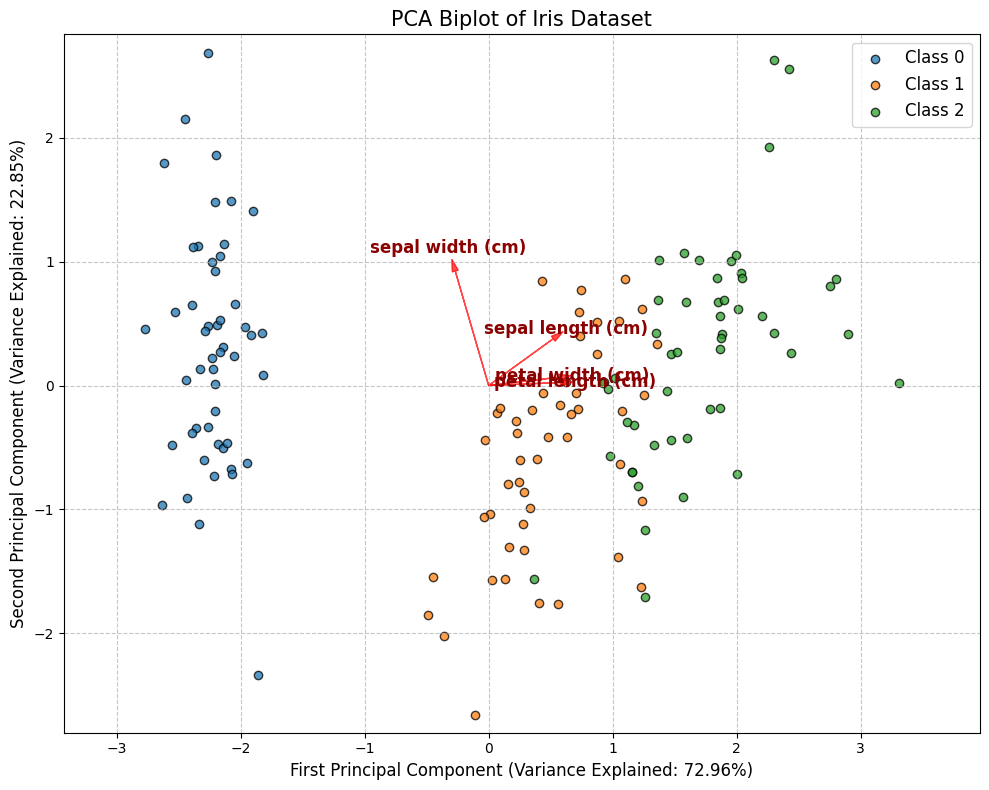

In [31]:
create_enhanced_biplot(pca, data_x, iris.target, iris.feature_names)